In [1]:
from __future__ import division, print_function

import numpy as np
import pandas as pd
from scipy import optimize

import pymc3 as mc

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [3]:
import theano.tensor as t

def tdot(x,b):
    return t.dot(x,b)

In [4]:
train = pd.read_csv('train.csv', index_col='Id')
test = pd.read_csv('test.csv', index_col='Id')

In [5]:
print(train.shape)

(50999, 33)


In [6]:
train.head()

,Hazard,T1_V1,T1_V2,T1_V3,T1_V4,T1_V5,T1_V6,T1_V7,T1_V8,T1_V9,...,T2_V6,T2_V7,T2_V8,T2_V9,T2_V10,T2_V11,T2_V12,T2_V13,T2_V14,T2_V15
Id,,,,,,,,,,,,,,,,,,,,,
1,1,15,3,2,N,B,N,B,B,D,...,2,37,1,11,6,Y,N,E,2,2
2,4,16,14,5,H,B,N,B,B,C,...,2,22,1,18,5,Y,Y,E,2,1
3,1,10,10,5,N,K,N,B,B,E,...,6,37,2,14,6,Y,Y,E,6,1
4,1,18,18,5,N,K,N,B,B,E,...,2,25,1,1,6,Y,N,C,2,6
5,1,13,19,5,N,H,N,B,B,E,...,1,22,1,2,7,N,N,E,1,1


In [7]:
y = train['Hazard'].astype(np.float32).apply(np.log)

In [8]:
T1_V8 = pd.get_dummies(train['T1_V8']).astype(np.float32)

In [9]:
T1_V1 = train['T1_V1'].astype(np.float32)

In [10]:
T1_V2 = train['T1_V2'].astype(np.float32)

In [11]:
T2_V1 = train['T1_V1'].astype(np.float32)

In [12]:
T2_V2 = train['T2_V2'].astype(np.float32)

In [ ]:
with mc.Model() as model:
    
    b_0     = mc.Normal('b_0',     mu=0, sd=1)
    
    b_T1_V8 = mc.Normal('b_T1_V8', mu=0, sd=1, shape=T1_V8.shape[1])
    
    b_T1_V1 = mc.Normal('b_T1_V1', mu=0, sd=1)
    b_T1_V2 = mc.Normal('b_T1_V2', mu=0, sd=1)

    b_T2_V1 = mc.Normal('b_T2_V1', mu=0, sd=1)
    b_T2_V2 = mc.Normal('b_T2_V2', mu=0, sd=1)
    
    b_T1_V1_T1_V2 = mc.Normal('b_T1_V1_T1_V2', mu=0, sd=1)

    # Try modeling mu as lam ~ Exp()
    # Add ^2 and interactions of important variables
    
    mu = ( b_0
          + tdot(T1_V8, b_T1_V8)
          + (b_T1_V1 * T1_V1)
          + (b_T1_V2 * T1_V2)
          + (b_T2_V1 * T2_V1)
          + (b_T2_V2 * T2_V2)          
          + (b_T1_V1_T1_V2 * T1_V1 * T1_V2)
          )
    
    s = mc.HalfNormal('s', 1)
    
    haz = mc.Normal('haz', mu=mu, sd=s, observed=y)
    
    start = mc.find_MAP(model=model, fmin=optimize.fmin_powell)
    step = mc.NUTS(scaling=start)    
    trace = mc.sample(1000, step, start=start, random_seed=27)

/home/walter/envs/property/miniconda/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


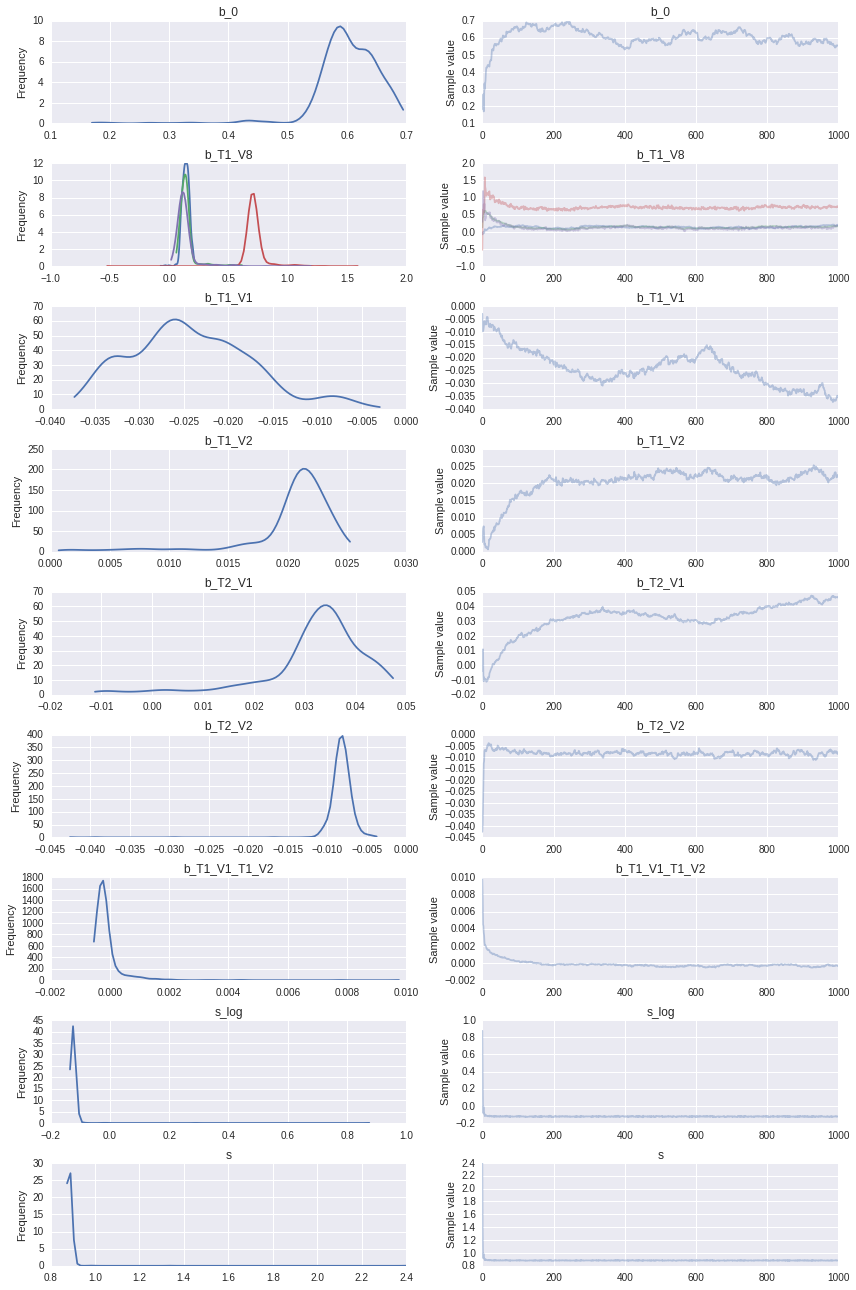

In [14]:
mc.traceplot(trace);

In [15]:
mu_mean = ( trace['b_0'].mean()
      + np.dot(T1_V8, trace['b_T1_V8'].T).mean(1)
      + (trace['b_T1_V1'].mean() * T1_V1)
      + (trace['b_T1_V2'].mean() * T1_V2)
      + (trace['b_T2_V1'].mean() * T2_V1)
      + (trace['b_T2_V2'].mean() * T2_V2)
      + (trace['b_T1_V1_T1_V2'].mean() * T1_V2 * T1_V1)
      )

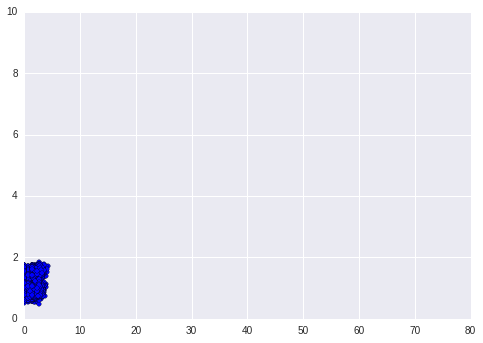

In [16]:
plt.scatter(y,mu_mean)
plt.xlim((0,80))
plt.ylim((0,10))
plt.show()

In [17]:
mu = ( trace['b_0'][np.newaxis, :]
      + np.dot(T1_V8, trace['b_T1_V8'].T)
      + (trace['b_T1_V1'][np.newaxis, :] * T1_V1[:,np.newaxis])
      + (trace['b_T1_V2'][np.newaxis, :] * T1_V2[:,np.newaxis])
      + (trace['b_T2_V1'][np.newaxis, :] * T2_V1[:,np.newaxis])
      + (trace['b_T2_V2'][np.newaxis, :] * T2_V2[:,np.newaxis])
      + (trace['b_T1_V1_T1_V2'][np.newaxis, :] * (T1_V2 * T1_V1)[:,np.newaxis])
      )

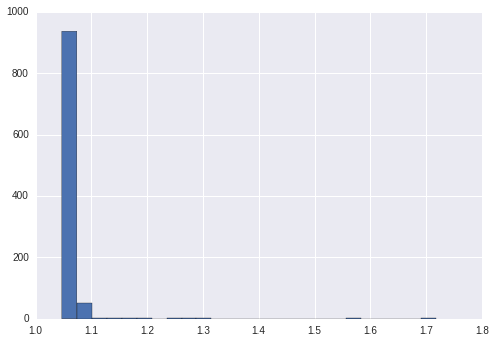

In [18]:
plt.hist(mu[100,:], 25);

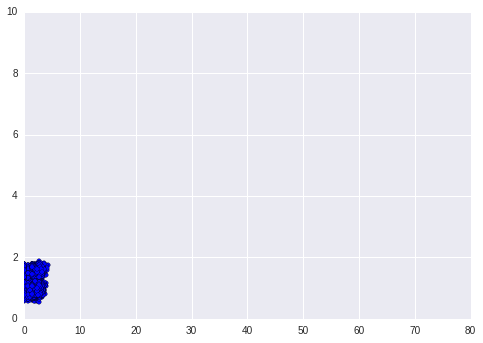

In [19]:
plt.scatter(y,np.percentile(mu, 90, axis=1))
plt.xlim((0,80))
plt.ylim((0,10))
plt.show()

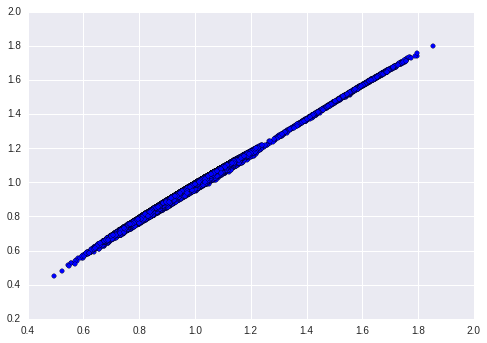

In [20]:
plt.scatter(mu_mean,np.percentile(mu, 10, axis=1))
plt.show()